# Intro to PyO3 - Image Convolutions

## Prelude: PyO3 & Maturin

![](https://miro.medium.com/v2/resize:fit:1400/1*S8Xs5c-Io9DHGmaXRY2mog.png)

## Deconstructing images

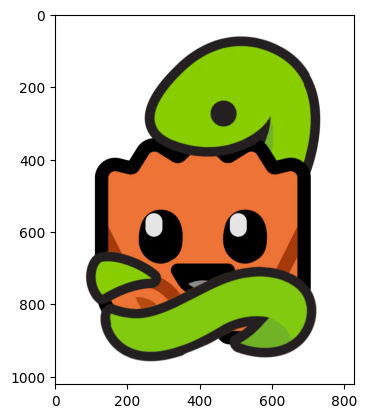

(1022, 827, 4)

In [1]:
import imageio.v3 as iio
from pathlib import Path
import matplotlib.pyplot as plt

filepath = Path.cwd().parent / "data/pyrs.png"
img = iio.imread(filepath)
plt.imshow(img)
plt.show()
img.shape

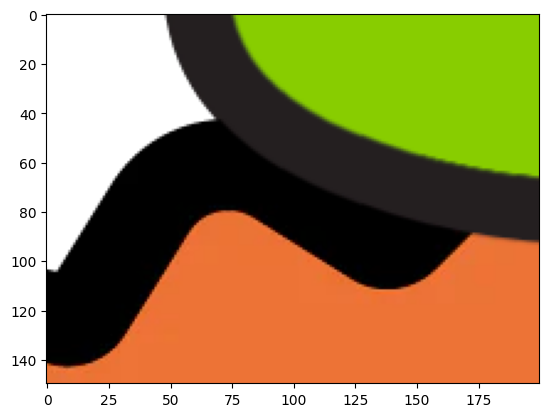

In [2]:
img_slice = img[300:450, 200:400, :]
plt.imshow(img_slice)
plt.show()

In [3]:
# img_slice[:,:,0], img_slice[:,:,1],img_slice[:,:,2],img_slice[:,:,3]
img_slice[:, :, 0]

array([[  0,   0,   0, ..., 136, 136, 136],
       [  0,   0,   0, ..., 136, 136, 136],
       [  0,   0,   0, ..., 136, 136, 136],
       ...,
       [235, 234, 233, ..., 237, 237, 237],
       [235, 234, 233, ..., 237, 237, 237],
       [235, 235, 234, ..., 237, 237, 237]], dtype=uint8)

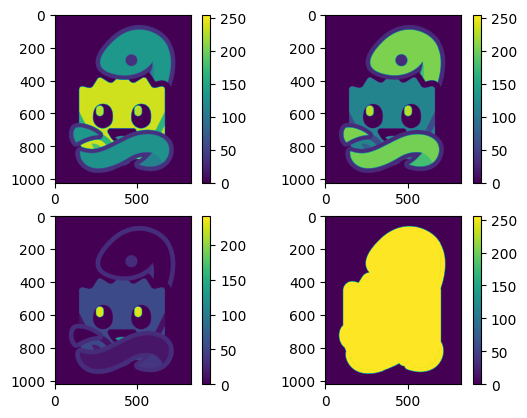

In [4]:
fig, axs = plt.subplots(2, 2)
for i in range(4):
    _im = img[:, :, i]
    ax = axs[i // 2, i % 2]
    _imshow = ax.imshow(_im)
    fig.colorbar(_imshow)

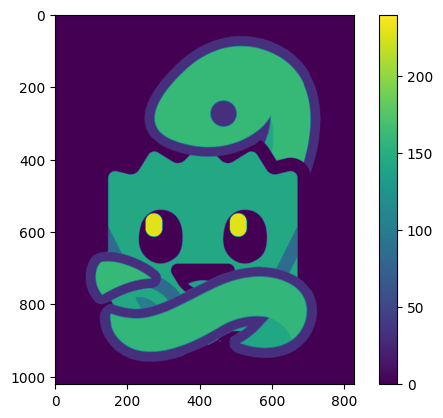

(1022, 827)

In [5]:
import numpy as np

img_gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
plt.imshow(img_gray)  # cmap='gray'
plt.colorbar()
plt.show()
img_gray.shape

## Convolutions
![](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

In [6]:
import inspect
from pygments import highlight, lexers, formatters
from sobel_py import convolution2d

print(
    highlight(
        inspect.getsource(convolution2d),
        lexers.PythonLexer(),
        formatters.TerminalFormatter(),
    )
)

def convolution2d(
    image: np.ndarray,
    kernel: np.ndarray,
    padding: int | None = 0,
) -> np.ndarray:
    """2D convolution of an image (stride is 1)."""
    if len(image.shape) != 2:  # noqa: PLR2004
        raise ValueError(f"Expected 2D image, got ({image.shape}).")
    if padding is not None and padding < 0:
        raise ValueError(f"Padding must be non-negative, got {padding}.")
    kernel_y, kernel_x = kernel.shape
    if kernel_y != kernel_x:
        raise ValueError("Expected square kernels, got ({m}, {n}) kernel.")

    padded_image = (
        np.pad(image, (padding, padding), constant_values=0)
        if padding is not None
        else image
    )
    out_img = np.zeros(padded_image.shape)
    img_y, img_x = image.shape
    for i in range(img_y - kernel_y + 1):
        for j in range(img_x - kernel_y + 1):
            out_img[i][j] = np.sum(image[i : i + kernel_y, j : j + kernel_y] * kernel)
    return out_img.astype(np.uint8)



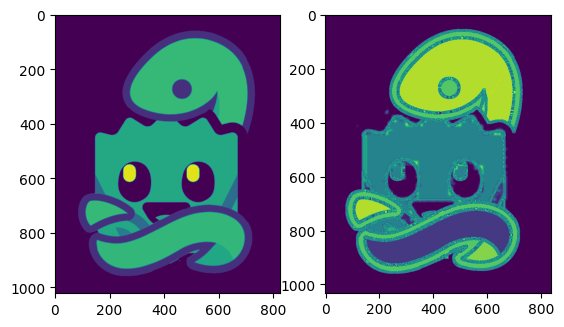

((1022, 827), (1032, 837))

In [7]:
from sobel_py import sidebyside

kernel = np.ones((10, 10))
norm_kernel = kernel / np.sum(kernel)
padding = kernel.shape[0] // 2


img_out = convolution2d(img_gray, kernel=kernel, padding=padding)

sidebyside(img_gray, img_out)
plt.show()
img_gray.shape, img_out.shape

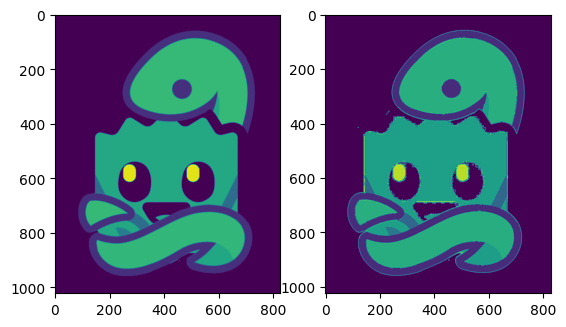

In [8]:
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # sharpen
padding = kernel.shape[0] // 2

img_out = convolution2d(img_gray.astype(np.uint8), kernel=kernel, padding=padding)
sidebyside(img_gray, img_out)
plt.show()

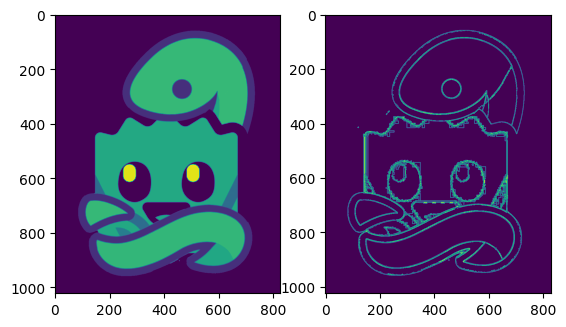

In [9]:
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
kernel = np.ones((3, 3)) * -1
kernel[1, 1] = 8  # edge
padding = kernel.shape[0] // 2

img_out = convolution2d(
    img_gray.astype(np.uint8), kernel=kernel, padding=padding
).astype(np.uint8)
sidebyside(img_gray, img_out)
plt.show()

### Your assignment:

1. Create a new `sobel_rs` package for our Rust implementation
2. Recreate the `convolution2d` function in Rust 🦀 (check out: [`ndarray_for_numpy_users`](https://docs.rs/ndarray/latest/ndarray/doc/ndarray_for_numpy_users/index.html))
   1. Create a "Matrix" `struct` for our matrices that should take a `Vec<f32>` for values and `(usize, usize)` for the shape and can return a `ndarray::Array2`
   2. You'll also need some Python helper functions to create the matrices from NumPy arrays and convert them back
3. Apply the [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator) to the image and visualize the results!
   1. Broadcast the grayscale to RGB channels
   2. Add extra color to the horizontal and vertical edges (different colors)
   3. Compare the performance of the Python implementation and Rust ones
4. Add the Python functions as part of `sobel_rs` to make a [Mixed Rust/Python project](https://www.maturin.rs/project_layout#mixed-rustpython-project)

```bash
source .venv/bin/activate
maturin --help
maturin new sobel_rs
cd sobel_rs
tree . --gitignore -a
maturin develop
```

In [ ]:
!pygmentize ../sobel_rs/src/lib.rs

In [ ]:
from sobel_rs import sum_as_string

sum_as_string(1, 2)

### Going further

1. Try access the NumPy arrays from Rust directly and manipulate it in-place (hint: look for zero copy for PyO3 and NumPy)
2. Parallelize the Rust implementation with [Rayon](https://github.com/rayon-rs/rayon)
   1. Compare the results!